In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import wfdb
import glob
from wfdb import processing
import scipy
from scipy import *
sns.set()

In [ ]:
data_files = glob.glob('C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih/*.atr')
data_files = [i[:-4] for i in data_files]
data_files.sort()
print(data_files)

In [ ]:
classes = ['N','R','L','V','A','E']
record_nums =[]
record_names = []
num_beats =[]

for i in range(len(data_files)):
    signals, fields = wfdb.rdsamp(data_files[i])
    annotation = wfdb.rdann(data_files[i], 'atr')
    record_nums.append(i)
#   record_names.append(data_files[i])
    for j in classes:
        ids = np.in1d(annotation.symbol, j)
        beats = annotation.sample[ids]
        num_beats.append(len(beats))
        
n_vals = num_beats[::6]
r_vals = num_beats[1::6]
l_vals = num_beats[2::6]
v_vals = num_beats[3::6]
a_vals = num_beats[4::6]
e_vals = num_beats[5::6]

In [ ]:
import wfdb as wf
import numpy as np
import glob
from matplotlib import pyplot as plt
from biosppy.signals import ecg
from scipy import signal

def extract_data():
    data_files = glob.glob('C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih/*.atr')
    data_files = [i[:-4] for i in data_files]
    data_files.sort()
    return data_files

files = extract_data()
i=0

good_beats =['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']
list_anns = []

for i in range(len(files)):
    datfile = files[i]
    record = wf.rdsamp(datfile)
    ann = wf.rdann(datfile, 'atr')
    list_anns.extend(ann.symbol)

dict_anns = {}

for i in list_anns:
    dict_anns[i] = dict_anns.get(i,0)+1
    
dict_anns = {k:v for k,v in dict_anns.items() if k in good_beats}

print(dict_anns.values())

plt.figure(figsize=(12,6))

xlocs, xlabs = plt.xticks()
barplt = plt.bar(list(dict_anns.keys()),dict_anns.values(),width = .6)
xlocs = [j for j in dict_anns.keys()]
ylabs = [j for j in dict_anns.values()]

plt.title('Annotation Distribution for all Classes in the Dataset')
plt.xlabel('Annotations')
plt.ylabel('Counts')

for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1000, yval)
    
plt.show()

In [ ]:
import wfdb as wf
import numpy as np
import glob
from matplotlib import pyplot as plt
from biosppy.signals import ecg
from scipy import signal

def extract_data():
    data_files = glob.glob('C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih/*.atr')
    data_files = [i[:-4] for i in data_files]
    data_files.sort()
    return data_files

records = extract_data()
print('Total files: ', len(records))


good_beats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

for path in records:
    pathpts = path.split('/')
    fn = pathpts[-1]
    print('Loading file:', path)

    # Read in the data
    record = wf.rdsamp(path)
    annotation = wf.rdann(path, 'atr')

    # Print some meta informations
    print('    Sampling frequency used for this record:', record[1].get('fs'))
    print('    Shape of loaded data array:', record[0].shape)
    print('    Number of loaded annotations:', len(annotation.num))
    
    # Get the ECG values from the file.
    data = record[0].transpose()

    # Generate the classifications based on the annotations.
    # 0.0 = undetermined
    # 1.0 = normal
    # 2.0 = LBBBB
    # 3.0 = RBBBB
    # 4.0 = Premature Ventricular contraction
    # 5.0 = Atrial Premature beat
    # 6.0 = Fusion ventricular normal beat
    # 7.0 = Fusion of paced and normal beat
    # 8.0 = paced beat
    
    clas = np.array(annotation.symbol)
    rate = np.zeros_like(clas, dtype='float')
    for clasid, clasval in enumerate(clas):
        if (clasval == 'N'):
            rate[clasid] = 1.0 # Normal
        elif (clasval == 'L'):
            rate[clasid] = 2.0 # LBBBB
        elif (clasval == 'R'):
            rate[clasid] = 3.0 # RBBBB
        elif (clasval == 'V'):
            rate[clasid] = 4.0 # Premature Ventricular contraction
        elif (clasval == 'A'):
            rate[clasid] = 5.0 # Atrial Premature beat
        elif (clasval == 'F'):
            rate[clasid] = 6.0 # Fusion ventricular normal beat
        elif (clasval == 'f'):
            rate[clasid] = 7.0 # Fusion of paced and normal beat
        elif (clasval == '/'):
            rate[clasid] = 8.0 # paced beat
            
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate
    
    indices = np.arange(data[0].size, dtype='int')

    # Manipulate both channels
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)
        
        # Find rpeaks in the ECG data. Most should match with
        # the annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)

        # Split into individual heartbeats. For each heartbeat
        # record, append classification.
        
        beats = []
        for ind, ind_val in enumerate(out['rpeaks']):

            start,end = ind_val-220//2, ind_val+220//2
            if start < 0:
                start = 0
            diff = 220 - len(channel[start:end])
            if diff > 0:
                padding = np.zeros(diff, dtype='float')
                padded_channel = np.append(padding, channel[start:end])
                beats.append(padded_channel)
            else:
                beats.append(channel[start:end])

            # Get the classification value that is on
            # or near the position of the rpeak index.
            from_ind = 0 if ind_val < 10 else ind_val - 10
            to_ind = ind_val + 10
            clasval = rates[from_ind:to_ind].max()
            
            # Standardize the data
            beats[ind] = ((beats[ind] - np.mean(beats[ind])) / np.std(beats[ind]))

            # Append the classification to the beat data.
            beats[ind] = np.append(beats[ind], clasval)
            
            # Append the record number to the beat data.
            beats[ind] = np.append(beats[ind], fn[-3:])

        # Save to CSV file.

        savedata = np.array(beats[:], dtype=np.float)
        outfn = 'C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/'+fn+'_'+chname+'.csv'
        print('    Generating ', outfn)
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

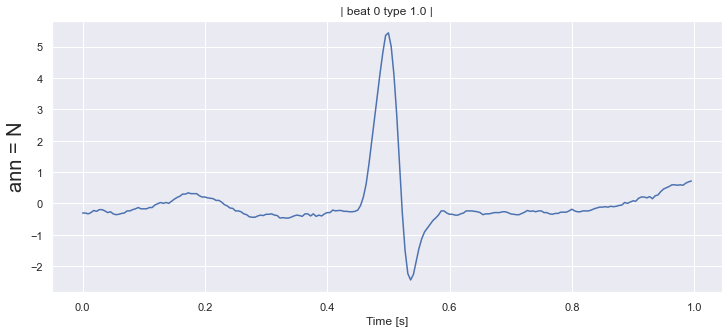

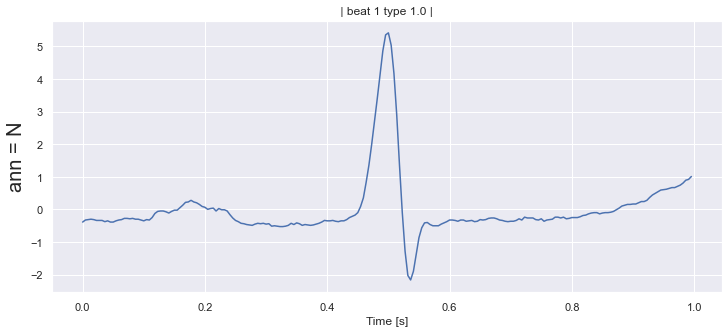

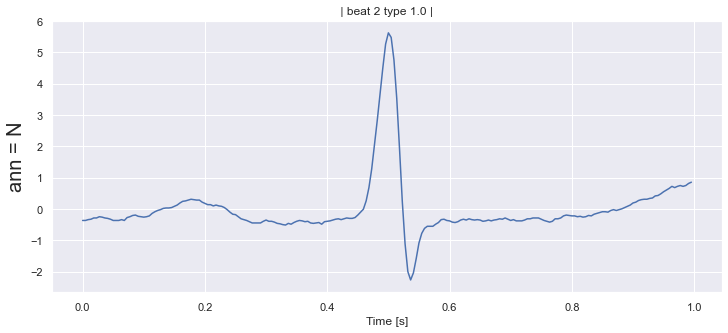

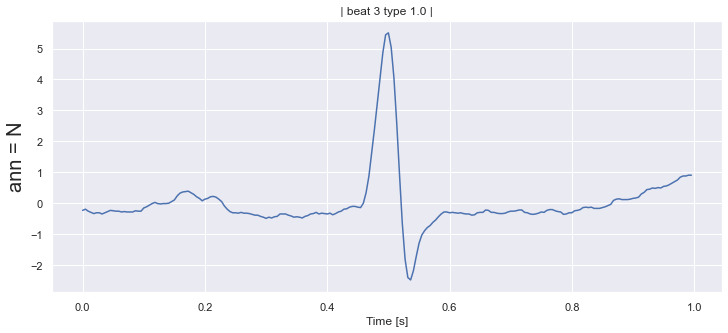

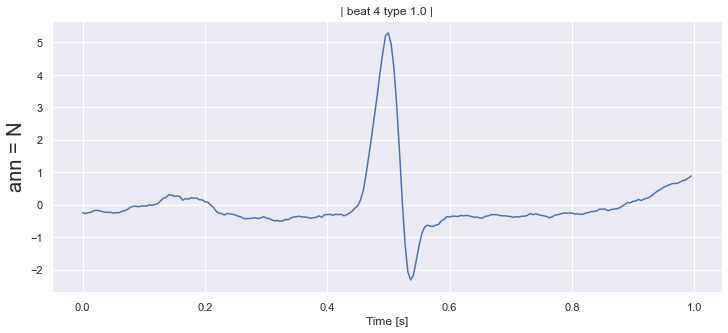

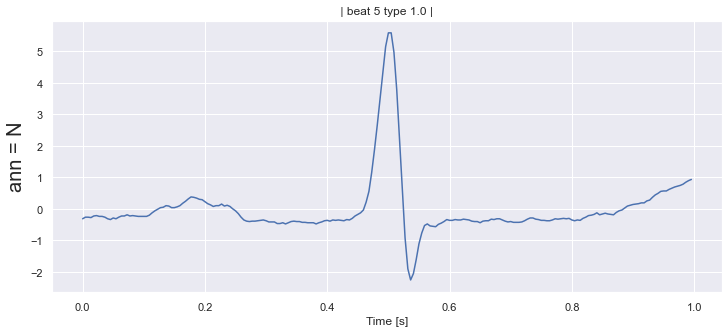

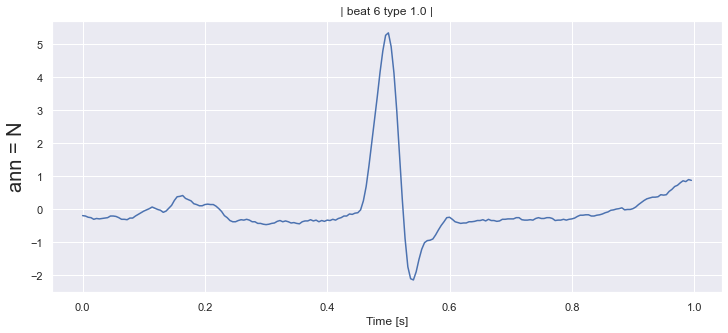

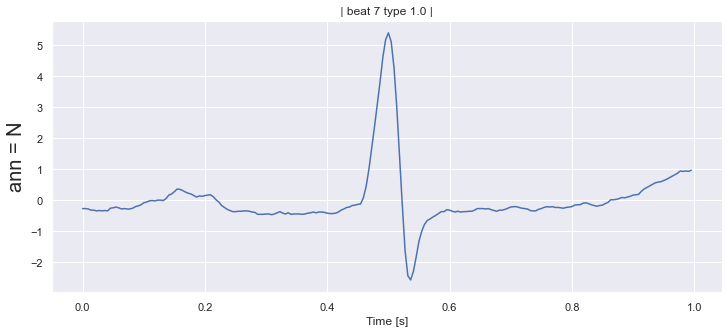

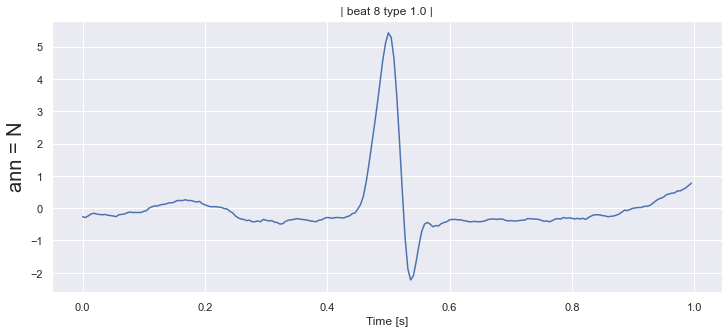

In [5]:
csv_data = np.loadtxt('C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih/123_MLII.csv', delimiter=',')

beat_num = [0,1,2,3,4,5,6,7,8]

for beatid in beat_num:
    times = np.arange(220, dtype = 'float')/220
    beat = csv_data[beatid][:-2]
    anno = csv_data[beatid][-2]
    
    plt.figure(figsize=(12,5))
    
    if (anno == 1.0):
        plt.plot(times, beat, 'b')
        plt.ylabel('ann = N', size=20)
    elif(anno == 2.0):
        plt.plot(times, beat, 'r')
        plt.ylabel('ann = L', size=20)
    elif(anno == 3.0):
        plt.plot(times, beat, 'g')
        plt.ylabel('ann = R', size=20)
    elif(anno == 4.0):
        plt.plot(times, beat, 'y')
        plt.ylabel('ann = V', size=20)
    elif(anno == 5.0):
        plt.plot(times, beat, 'c')
        plt.ylabel('ann = A', size=20)
    elif(anno == 6.0):
        plt.plot(times, beat, 'm')
        plt.ylabel('ann = F', size=20)
    elif(anno == 7.0):
        plt.plot(times, beat, 'k')
        plt.ylabel('ann = f', size=20)
    elif(anno == 8.0):
        plt.plot(times, beat, 'm')
        plt.ylabel('ann = /', size=20)
        
    plt.xlabel('Time [s]')
    plt.title(' | beat ' + str(beatid) + " type " + str(anno)+' | ')
    plt.show()

## Generate the classifications based on the annotations.

* 0.0 = undetermined
* N = 1.0 = normal
* L = 2.0 = LBBBB
* R = 3.0 = RBBBB
* V = 4.0 = Premature Ventricular contraction
* A = 5.0 = Atrial Premature beat
* F = 6.0 = Fusion ventricular normal beat
* f = 7.0 = Fusion of paced and normal beat
* / = 8.0 = paced beat

In [2]:
alldata = np.empty(shape=[0, 222])
print(alldata.shape)
all_csvs = glob.glob('C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih/*.csv')
for j in all_csvs:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)
    
print(alldata.shape)

(0, 222)
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\100_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\100_V5.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\101_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\101_V1.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\102_V2.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\102_V5.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\103_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\103_V2.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\104_V2.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\104_V5.csv
Loading  C:/Users/shour/Desktop/Compsci project workspa

Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\231_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\231_V1.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\232_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\232_V1.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\233_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\233_V1.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\234_MLII.csv
Loading  C:/Users/shour/Desktop/Compsci project workspace/cs_lvl4_project/mit-bih\234_V1.csv
(215361, 222)


In [3]:
no_anno = np.where(alldata[:,-2]==0.0)[0]
print(no_anno.shape)
alldata = np.delete(alldata, no_anno,0)
print(alldata.shape)

(63909,)
(151452, 222)


In [4]:
print(alldata.shape)

from sklearn.model_selection import train_test_split
train, test = train_test_split(alldata,test_size=0.25,random_state=48)

print(train.shape)
print(test.shape)

(151452, 222)
(113589, 222)
(37863, 222)


In [5]:
with open('all_data.csv', "wb") as fin:
    np.savetxt(fin, alldata, delimiter=",", fmt='%f')

In [6]:
with open('train_unsampled_all_220.csv', "wb") as fin:
    np.savetxt(fin, train, delimiter=",", fmt='%f')

In [7]:
with open('test_unsampled_all_220.csv', "wb") as fin:
    np.savetxt(fin, test, delimiter=",", fmt='%f')

In [8]:
from sklearn.utils import resample

N = train[train[:,-2]==1.0]
L = train[train[:,-2]==2.0]
R = train[train[:,-2]==3.0]
V = train[train[:,-2]==4.0]
A = train[train[:,-2]==5.0]
F = train[train[:,-2]==6.0]
f = train[train[:,-2]==7.0]
I = train[train[:,-2]==8.0]

seed=42
np.random.seed(seed)
def downsample(arr, n, seed):
    downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
    return downsampled

def upsample(arr, n, seed):
    upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

all_class = [N,L,R,V,A,F,f,I]
abn_class = [L,R,V,A,F,f,I]

mean_val = np.mean([len(i) for i in abn_class], dtype= int)
train_sampled = []

for i in all_class:
    if i.shape[0]> mean_val:
        i = downsample(i,mean_val,seed)
    elif i.shape[0]< mean_val:
        i = upsample(i, mean_val,seed)
    train_sampled.append(i)
    
train_sampled = np.concatenate(train_sampled)
np.random.shuffle(train_sampled)
train_sampled_all = train_sampled

with open('train_sampled_all_220.csv', "wb") as fin:
    np.savetxt(fin, train_sampled_all, delimiter=",", fmt='%f')

In [9]:
N = test[test[:,-2]==1.0]
L = test[test[:,-2]==2.0]
R = test[test[:,-2]==3.0]
V = test[test[:,-2]==4.0]
A = test[test[:,-2]==5.0]
F = test[test[:,-2]==6.0]
f = test[test[:,-2]==7.0]
I = test[test[:,-2]==8.0]

seed=42
np.random.seed(seed)
def downsample(arr, n, seed):
    downsampled = resample(arr,replace=False,n_samples=n, random_state=seed)
    return downsampled

def upsample(arr, n, seed):
    upsampled = resample(arr,replace=True,n_samples=n,random_state=seed)
    return upsampled

all_class = [N,L,R,V,A,F,f,I]
abn_class = [L,R,V,A,F,f,I]

mean_val = np.mean([len(i) for i in abn_class], dtype= int)
test_sampled = []

for i in all_class:
    if i.shape[0]> mean_val:
        i = downsample(i,mean_val,seed)
    elif i.shape[0]< mean_val:
        i = upsample(i, mean_val,seed)
    test_sampled.append(i)
    
test_sampled = np.concatenate(test_sampled)
np.random.shuffle(test_sampled)
test_sampled_all = test_sampled
    
with open('test_sampled_all_220.csv', "wb") as fin:
    np.savetxt(fin, test_sampled_all, delimiter=",", fmt='%f')

In [ ]:
feature_names = ['N','L','R','V','A','F','f','/']

dftrain = pd.DataFrame(train)
countstrain = dftrain[187].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstrain.index, countstrain.values, alpha=0.8, color='orange')
plt.title('Training Unsampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+1000, yval)
plt.show()

df_sampled = pd.DataFrame(train_sampled_all)
counts = df_sampled[187].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(counts.index, counts.values, alpha=0.8, color='b')
plt.title('Training Sampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+30, yval)
plt.show()

dftest = pd.DataFrame(test)
countstest = dftest[187].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstest.index, countstest.values, alpha=0.8, color='r')
plt.title('Testing Unsampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+600, yval)
plt.show()

dftest_sampled = pd.DataFrame(test_sampled_all)
countstestsam = dftest_sampled[187].value_counts()

plt.figure(figsize=(10,5))
barplt = plt.bar(countstestsam.index, countstestsam.values, alpha=0.8, color='g')
plt.title('Testing Sampled Label Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Beat Category', fontsize=12)
plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
for bar in barplt:
    yval = bar.get_height()
    plt.text(bar.get_x()+.2, yval+20, yval)
plt.show()